In [33]:
# Generate graphs for demonstration purposes
import utils.graph_generators as gen
import torch
import dgl
a=gen.load_zinc(n_samples=10)

In [5]:
#nx_a = [dgl.to_networkx(a.cpu())  for a in a]

In [43]:

lobsters = [ dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])  for g in a]
grids = [dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat']) for g in a]

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device=torch.device('cpu')

grids = [ dgl.from_networkx(g,node_attrs=[], edge_attrs=[]).to(device) for g in grids] # Convert graphs to DGL from NetworkX
lobsters = [ dgl.from_networkx(g,node_attrs=[], edge_attrs=[]).to(device) for g in lobsters] # Convert graphs to DGL from NetworkX

In [27]:
print(grids[0],"\n", lobsters[0])

Graph(num_nodes=29, num_edges=64,
      ndata_schemes={}
      edata_schemes={}) 
 Graph(num_nodes=29, num_edges=64,
      ndata_schemes={}
      edata_schemes={})


In [44]:
# Compute all GNN-based metrics at once
from evaluation.evaluator import Evaluator
evaluator = Evaluator(device=device)
evaluator.evaluate_all(generated_dataset=grids, reference_dataset=lobsters)

orthogonal


{'activations_time': 0.03408217430114746,
 'fid': -5.350946508997367e-06,
 'fid_time': 0.03989291191101074,
 'kid': -0.55454874,
 'kid_time': 0.06699514389038086,
 'precision': 1.0,
 'recall': 1.0,
 'f1_pr': 1.00001,
 'precision_time': 0.08893966674804688,
 'recall_time': 0.08893966674804688,
 'f1_pr_time': 0.08893966674804688,
 'density': 1.2000000000000002,
 'coverage': 1.0,
 'f1_dc': 1.090919173552968,
 'density_time': 0.06998586654663086,
 'coverage_time': 0.06998586654663086,
 'f1_dc_time': 0.06998586654663086,
 'mmd_rbf': 0,
 'mmd_rbf_time': 0.07298421859741211,
 'mmd_linear': 0.0,
 'mmd_linear_time': 0.03408217430114746}

In [45]:
 #Alternatively, compute a single GNN-based metric. See evaluation/gin_evaluation.py for other metrics.
from evaluation.gin_evaluation import load_feature_extractor, MMDEvaluation

# Can tweak GIN hyperparameters, however defaults are set to our recommendations
gin = load_feature_extractor(device=device)
# Can tweak hyperparameters of MMD RBF, however defaults are set to our recommendations
mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=lobsters)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

orthogonal
result: {'mmd_rbf': 0}, time to compute: 0.085s


In [46]:
# Evaluation incorporating custom node/edge features.
# If no node features are provided, the default is degree features
# expressed as an integer.

node_feat_loc = 'feat'
edge_feat_loc = 'feat'
node_feat_dim = 10
edge_feat_dim = 5

# Create random node/edge features
for g in grids:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)
    
for g in lobsters:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)

# Load GIN
gin = load_feature_extractor(
    device=device, input_dim=node_feat_dim, edge_feat_dim=edge_feat_dim,
    node_feat_loc=node_feat_loc, edge_feat_loc=edge_feat_loc)

mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=lobsters, reference_dataset=grids)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

orthogonal
result: {'mmd_rbf': 0.20000000298023224}, time to compute: 0.085s


In [50]:
# To quickly demonstrate sensitivity to node/edge features, let's create
# a copy of the grid graphs and slightly alter the node/edge feat distributions
import copy

result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=grids)
print('MMD RBF for grids with itself: {}'.format(result['mmd_rbf']))

grids_copy = [copy.deepcopy(g) for g in grids]
for g in grids_copy:
    g.ndata[node_feat_loc] *= 1.15
    g.edata[edge_feat_loc] *= 1.15
    
result, time = mmd_eval.evaluate(reference_dataset=grids, generated_dataset=grids_copy)
print('MMD RBF after altering node/edge feat. distributions: {}'.format(result['mmd_rbf']))

MMD RBF for grids with itself: 0
MMD RBF after altering node/edge feat. distributions: 0.20000000298023224


In [51]:
a=gen.load_zinc(n_samples=10)
grids=a
lobsters=a
print(len(grids[0].ndata['attr']))
print(grids[0].ndata['attr']  , grids[0].ndata['feat'])

29
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [58]:

lobsters = [ dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])  for g in a]
grids = [dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat']) for g in a]

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device=torch.device('cpu')

grids = [ dgl.from_networkx(g,node_attrs=['feat'], edge_attrs=['feat']).to(device) for g in grids] # Convert graphs to DGL from NetworkX
lobsters = [ dgl.from_networkx(g,node_attrs=['feat'], edge_attrs=['feat']).to(device) for g in lobsters] # Convert graphs to DGL from NetworkX

In [59]:
# Compute all GNN-based metrics at once
from evaluation.evaluator import Evaluator
evaluator = Evaluator(device=device)
evaluator.evaluate_all(generated_dataset=grids, reference_dataset=lobsters)

orthogonal


{'activations_time': 0.037894248962402344,
 'fid': -5.747745163375839e-06,
 'fid_time': 0.04686927795410156,
 'kid': -0.6127095,
 'kid_time': 0.06581926345825195,
 'precision': 1.0,
 'recall': 1.0,
 'f1_pr': 1.00001,
 'precision_time': 0.09274744987487793,
 'recall_time': 0.09274744987487793,
 'f1_pr_time': 0.09274744987487793,
 'density': 1.2000000000000002,
 'coverage': 1.0,
 'f1_dc': 1.090919173552968,
 'density_time': 0.07080650329589844,
 'coverage_time': 0.07080650329589844,
 'f1_dc_time': 0.07080650329589844,
 'mmd_rbf': 0,
 'mmd_rbf_time': 0.08466887474060059,
 'mmd_linear': 0.0,
 'mmd_linear_time': 0.03889155387878418}

In [60]:
 #Alternatively, compute a single GNN-based metric. See evaluation/gin_evaluation.py for other metrics.
from evaluation.gin_evaluation import load_feature_extractor, MMDEvaluation

# Can tweak GIN hyperparameters, however defaults are set to our recommendations
gin = load_feature_extractor(device=device)
# Can tweak hyperparameters of MMD RBF, however defaults are set to our recommendations
mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=lobsters)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

orthogonal
result: {'mmd_rbf': 0}, time to compute: 0.080s


In [85]:
# Evaluation incorporating custom node/edge features.
# If no node features are provided, the default is degree features
# expressed as an integer.

node_feat_loc = 'feat'
edge_feat_loc = 'feat'
node_feat_dim = 10
edge_feat_dim = 5

# Create random node/edge features
for g in grids:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)
    
for g in lobsters:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)

# Load GIN
gin = load_feature_extractor(
    device=device, input_dim=node_feat_dim, edge_feat_dim=edge_feat_dim,
    node_feat_loc=node_feat_loc, edge_feat_loc=edge_feat_loc)

mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=lobsters, reference_dataset=grids)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

orthogonal
result: {'mmd_rbf': 0}, time to compute: 0.110s


In [65]:
# To quickly demonstrate sensitivity to node/edge features, let's create
# a copy of the grid graphs and slightly alter the node/edge feat distributions
import copy

result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=grids)
print('MMD RBF for grids with itself: {}'.format(result['mmd_rbf']))

grids_copy = [copy.deepcopy(g) for g in grids]
for g in grids_copy:
    g.ndata[node_feat_loc] *= 5
    g.edata[edge_feat_loc] *= 5
    
result, time = mmd_eval.evaluate(reference_dataset=grids, generated_dataset=grids_copy)
print('MMD RBF after altering node/edge feat. distributions: {}'.format(result['mmd_rbf']))

MMD RBF for grids with itself: 0
MMD RBF after altering node/edge feat. distributions: 0.9580309987068176


In [91]:
a=gen.load_zinc(n_samples=10)


In [92]:
grids=a
lobsters=a

In [174]:
test=grids[0]
test_nx=dgl.to_networkx(test, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])

In [94]:
test_nx.edges(data=True)

OutMultiEdgeDataView([(0, 1, {'id': 0, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (1, 0, {'id': 1, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (1, 2, {'id': 2, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (2, 1, {'id': 3, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (2, 3, {'id': 4, 'attr': tensor([0., 0., 1., 0.]), 'feat': tensor(2)}), (2, 28, {'id': 5, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (3, 2, {'id': 6, 'attr': tensor([0., 0., 1., 0.]), 'feat': tensor(2)}), (3, 4, {'id': 7, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (4, 3, {'id': 8, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (4, 5, {'id': 9, 'attr': tensor([0., 0., 1., 0.]), 'feat': tensor(2)}), (5, 4, {'id': 10, 'attr': tensor([0., 0., 1., 0.]), 'feat': tensor(2)}), (5, 6, {'id': 11, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (5, 27, {'id': 12, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (6, 5, {'id': 13, 'attr': tensor([0.,

In [101]:
(test.ndata["feat"])

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 5, 1, 1, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 0])

In [165]:
(test.edata["feat"])

tensor([1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2])

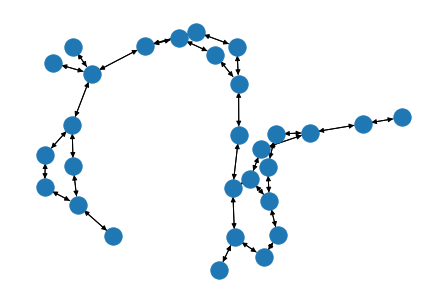

In [132]:
 import networkx as nx
 nx.draw(test_nx)

In [229]:

#https://github.com/graphdeeplearning/benchmarking-gnns/issues/42


dict_of_nodes={0: 'C',
 1: 'O',
 2: 'N',
 3: 'F',
 4: 'C',
 5: 'S',
 6: 'Cl',
 7: 'O',
 8: 'N',
 9: 'Br',
 10: 'N',
 11: 'N',
 12: 'N',
 13: 'N',
 14: 'S ',
 15: 'I',
 16: 'P',
 17: 'O',
 18: 'N',
 19: 'O',
 20: 'S',
 21: 'P',
 22: 'P',
 23: 'C',
 24: 'P',
 25: 'S',
 26: 'C',
 27: 'P'}

dict_of_atomic_no ={ 'C':6, 'O':8, 'N':7, 'F':9, 'S':16, 'Cl':17,  'Br':35, 'I':53, 'P':15}

res = dict_of_nodes
for n in test_nx.nodes(data=True):
    print(  dict_of_atomic_no[res[int(n[1]['feat'].numpy())]])
    break

6


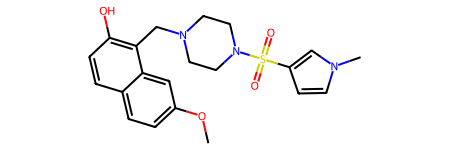

In [260]:

def get_atomic_number():
    dict_of_atomic_no ={ 'C':6, 'O':8, 'N':7, 'F':9, 'S':16, 'Cl':17,  'Br':35, 'I':53, 'P':15}
    return dict_of_atomic_no

def get_dict_of_nodes():
    dict_of_nodes={0: 'C', 1: 'O',2: 'N',3: 'F',4: 'C',5: 'S', 6: 'Cl', 7: 'O', 8: 'N',9: 'Br', 10: 'N', 11: 'N', 12: 'N', 13: 'N', 14: 'S ', 15: 'I', 16: 'P', 17: 'O', 18: 'N', 19: 'O',20: 'S', 21: 'P' ,22: 'P',23: 'C', 24: 'P',25: 'S',26: 'C',27: 'P'}
    return dict_of_nodes

def nx_to_mol(nx_graph , edge_label='feat', node_label='feat'):
    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    
    #dictionary of atomic numbers
    dict_of_atomic_no=get_atomic_number()
    
    #dictionary of nodes
    node_atom_values=get_dict_of_nodes()
    
    
    for i,n in enumerate(test_nx.nodes(data=True)):
        a = Chem.Atom( dict_of_atomic_no[node_atom_values[int(n[1][node_label].numpy())]])
        molIdx = mol.AddAtom(a)
        #print(molIdx)
        node_to_idx[i] = molIdx
        
    for edge in test_nx.edges(data=True):
            bond=int(edge[2][edge_label])
            ix=edge[0]
            iy=edge[1]
            
            # only traverse half the matrix
            if iy <= ix:
                continue
            if bond == 1:
                bond_type = Chem.rdchem.BondType.SINGLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 2:
                bond_type = Chem.rdchem.BondType.DOUBLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
                
            elif bond == 3:
                    bond_type=Chem.rdchem.BondType.Triple
                    mol.AddBond(node_to_idx[ix], node_to_idx[iy] ,bond_type)

        # Convert RWMol to Mol object
    mol = mol.GetMol()  
    return mol       

nx_to_mol(test_nx)

In [ ]:
# add bonds between adjacent atoms
for ix, row in enumerate(adjacency_matrix):
    for iy, bond in enumerate(row):
        \

        # only traverse half the matrix
        if iy <= ix:
            continue

        # add relevant bond type (there are many more of these)
        
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            
        elif bond == 3:
                bond_type=Chem.rdchem.BondType.Triple
                mol.AddBond(node_to_idx[ix], node_to_idx[iy] ,bond_type)

# Convert RWMol to Mol object
mol = mol.GetMol()            
#Chem.MolToSmiles

In [191]:
def MolFromGraphs(node_list, nx_graph):

    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    for i in range(len(node_list)):
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    # add bonds between adjacent atoms
    for ix, row in enumerate(adjacency_matrix):
        for iy, bond in enumerate(row):
            \

            # only traverse half the matrix
            if iy <= ix:
                continue

            # add relevant bond type (there are many more of these)
            
            elif bond == 1:
                bond_type = Chem.rdchem.BondType.SINGLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 2:
                bond_type = Chem.rdchem.BondType.DOUBLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
                
            elif bond == 3:
                 bond_type=Chem.rdchem.BondType.Triple
                 mol.AddBond(node_to_idx[ix], node_to_idx[iy] ,bond_type)

    # Convert RWMol to Mol object
    mol = mol.GetMol()            

    return mol
Chem.MolToSmiles(MolFromGraphs(node_list,  nx.adjacency_matrix(test_nx)))

C:\Users\cs843\AppData\Local\Temp\ipykernel_18672\747178566.py:39: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Chem.MolToSmiles(MolFromGraphs(node_list,  nx.adjacency_matrix(test_nx)))
[12:26:24] 

****
Post-condition Violation
Element 'S ' not found
Violation occurred on line 93 in file C:\rdkit\build\temp.win-amd64-cpython-310\Release\rdkit\Code\GraphMol\PeriodicTable.h
Failed Expression: anum > -1
****



RuntimeError: Post-condition Violation
	Element 'S ' not found
	Violation occurred on line 93 in file Code\GraphMol\PeriodicTable.h
	Failed Expression: anum > -1
	RDKIT: 2022.09.1
	BOOST: 1_75


In [217]:
adjacency_matrix=[[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
 [ 1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.],

 [ 0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.],

 [ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.],

 [ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],

 [ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.],

 [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],

 [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.]]

node_list=[6, 6, 7, 6, 6, 6, 6, 8] 
node_list=['C',' C', 'N', 'C', 'C', 'C', 'C', 'O']
MolFromGraphs(node_list, adjacency_matrix)

0
['C', ' C', 'N', 'C', 'C', 'C', 'C', 'O'] <rdkit.Chem.rdchem.Atom object at 0x0000018828E5B010>
1


[12:49:28] 

****
Post-condition Violation
Element ' C' not found
Violation occurred on line 93 in file C:\rdkit\build\temp.win-amd64-cpython-310\Release\rdkit\Code\GraphMol\PeriodicTable.h
Failed Expression: anum > -1
****



RuntimeError: Post-condition Violation
	Element ' C' not found
	Violation occurred on line 93 in file Code\GraphMol\PeriodicTable.h
	Failed Expression: anum > -1
	RDKIT: 2022.09.1
	BOOST: 1_75


In [214]:
def MolFromGraphs(node_list, adjacency_matrix):

    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    for i in range(len(node_list)):
        print(i)
        a = Chem.Atom(node_list[i])
        print(node_list,a)
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    # add bonds between adjacent atoms
    for ix, row in enumerate(adjacency_matrix):
        for iy, bond in enumerate(row):

            # only traverse half the matrix
            if iy <= ix:
                continue

            # add relevant bond type (there are many more of these)
            if bond == 0:
                continue
            elif bond == 1:
                bond_type = Chem.rdchem.BondType.SINGLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 2:
                bond_type = Chem.rdchem.BondType.DOUBLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

    # Convert RWMol to Mol object
    mol = mol.GetMol()            

    return mol
Chem.MolToSmiles(MolFromGraphs(nodes, a))

NameError: name 'nodes' is not defined